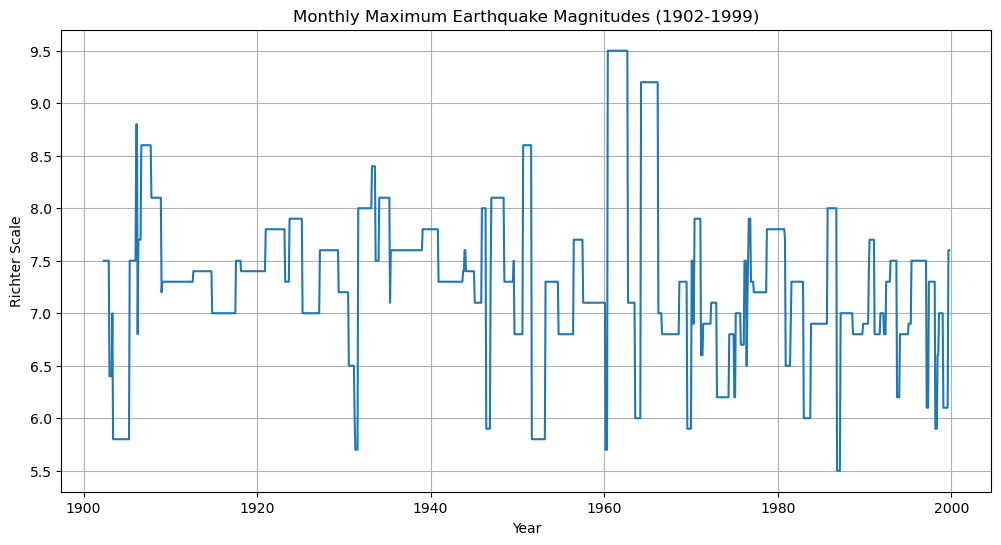

Results of Dickey-Fuller Test:
Test Statistic                -7.788613e+00
p-value                        8.053637e-12
#Lags Used                     1.000000e+00
Number of Observations Used    1.168000e+03
Critical Value (1%)           -3.435961e+00
Critical Value (5%)           -2.864018e+00
Critical Value (10%)          -2.568089e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.606598e+01
p-value                        5.572915e-29
#Lags Used                     5.000000e+00
Number of Observations Used    1.163000e+03
Critical Value (1%)           -3.435985e+00
Critical Value (5%)           -2.864028e+00
Critical Value (10%)          -2.568095e+00
dtype: float64


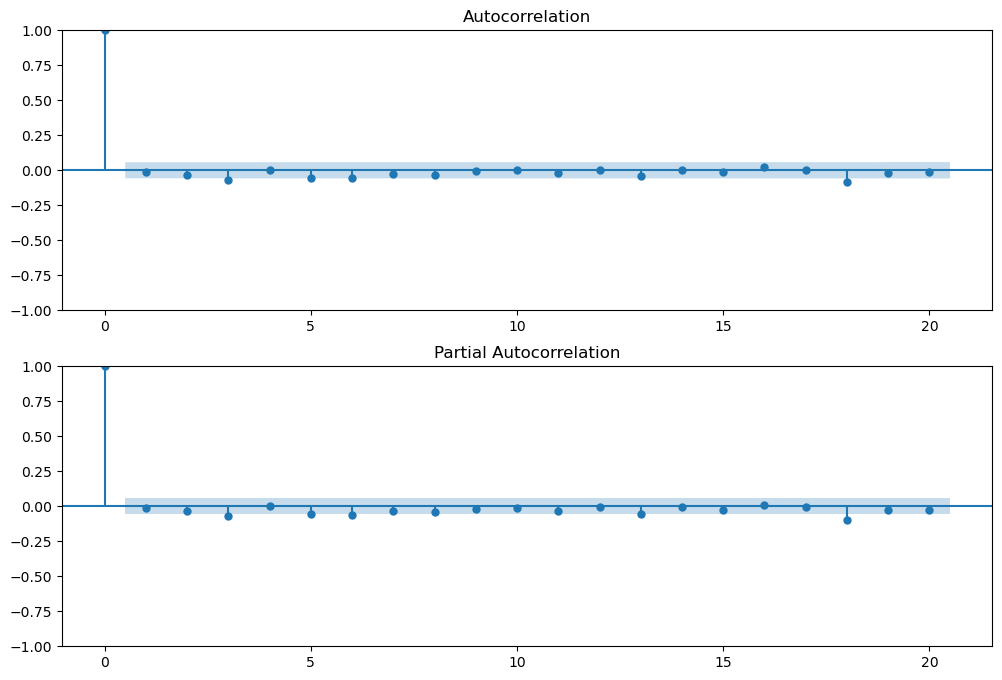

C:\Users\jenit\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\jenit\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                richter   No. Observations:                 1113
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -311.261
Date:                Tue, 22 Apr 2025   AIC                            628.523
Time:                        22:41:26   BIC                            643.564
Sample:                    04-30-1902   HQIC                           634.210
                         - 12-31-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9079      0.016     56.279      0.000       0.876       0.940
ma.L1         -0.9996      0.020    -50.816      0.000      -1.038      -0.961
sigma2         0.1021      0.002     45.446      0.0

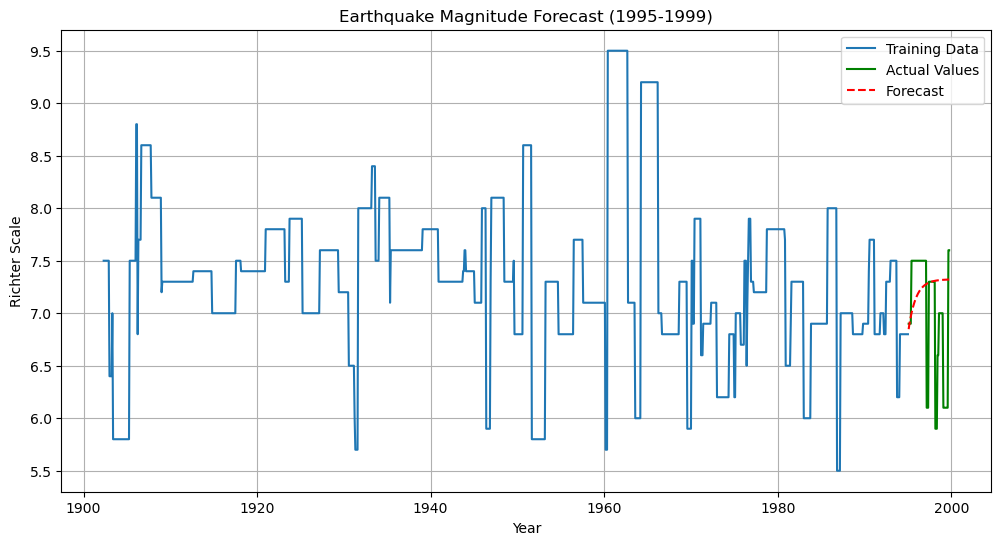

Test RMSE: 0.658

12-Month Future Forecast:
1995-01-31    6.848136
1995-02-28    6.891840
1995-03-31    6.931519
1995-04-30    6.967545
1995-05-31    7.000253
1995-06-30    7.029949
1995-07-31    7.056911
1995-08-31    7.081390
1995-09-30    7.103615
1995-10-31    7.123794
1995-11-30    7.142114
1995-12-31    7.158747
Freq: M, Name: predicted_mean, dtype: float64


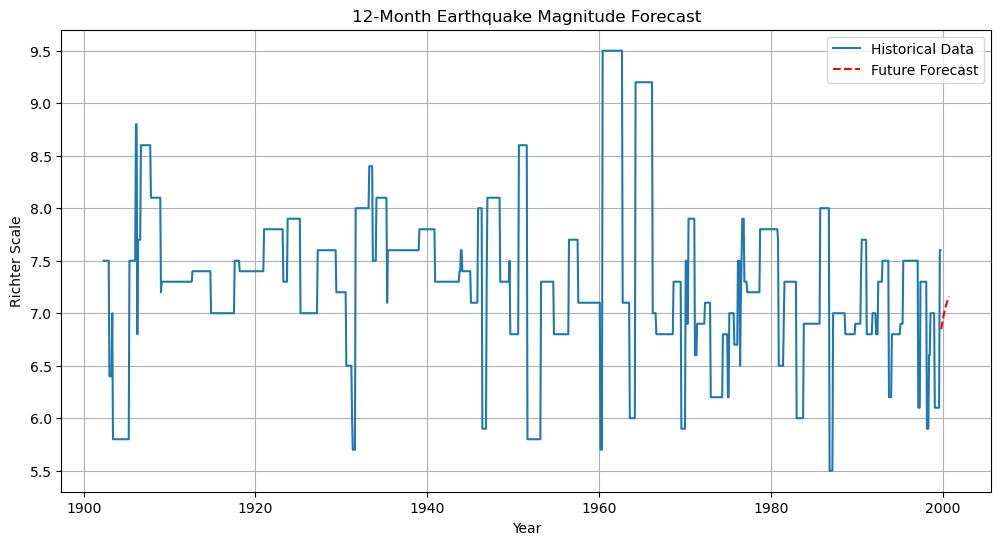

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime

# Load the data
df = pd.read_csv('earthquakes.csv')

# Convert month names to numbers
month_map = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6,
    'July': 7, 'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12
}
df['month'] = df['month'].map(month_map)

# Create datetime index
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Resample to monthly frequency (taking max magnitude per month)
ts = df['richter'].resample('M').max().ffill()  # Forward fill missing months

# Plot the original time series
plt.figure(figsize=(12, 6))
plt.plot(ts)
plt.title('Monthly Maximum Earthquake Magnitudes (1902-1999)')
plt.xlabel('Year')
plt.ylabel('Richter Scale')
plt.grid(True)
plt.show()

# Check for stationarity
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
test_stationarity(ts)

# Differencing to make series stationary
ts_diff = ts.diff().dropna()
test_stationarity(ts_diff)

# Plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts_diff, lags=20, ax=ax1)
plot_pacf(ts_diff, lags=20, ax=ax2, method='ywm')
plt.show()

# Split data into train and test sets (last 5 years for testing)
train = ts.loc[:'1994-12-31']
test = ts.loc['1995-01-31':]

# Fit ARIMA model - parameters determined from ACF/PACF
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Forecast
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Actual Values', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('Earthquake Magnitude Forecast (1995-1999)')
plt.xlabel('Year')
plt.ylabel('Richter Scale')
plt.legend()
plt.grid(True)
plt.show()

# Calculate RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f'Test RMSE: {rmse:.3f}')

# Forecast future values (next 12 months)
future_forecast = model_fit.forecast(steps=12)
print("\n12-Month Future Forecast:")
print(future_forecast)

# Plot future forecast
future_dates = pd.date_range(start=ts.index[-1] + pd.DateOffset(months=1), periods=12, freq='M')
plt.figure(figsize=(12, 6))
plt.plot(ts.index, ts, label='Historical Data')
plt.plot(future_dates, future_forecast, label='Future Forecast', color='red', linestyle='--')
plt.title('12-Month Earthquake Magnitude Forecast')
plt.xlabel('Year')
plt.ylabel('Richter Scale')
plt.legend()
plt.grid(True)
plt.show()